In [1]:
# Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import json
import os
from sympy import symbols, diff, lambdify, sympify

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [3]:
# Load the combined JSON data
with open('../../data/processed/swiss_rental_data_m2_construction_period/Durchschnittlicher_Mietpreis_m2_Bauperiode_Kanton_combined.json', 'r', encoding='utf-8') as f:
    rental_data = json.load(f)

# Function to convert nested JSON to a flat DataFrame
def flatten_json_data(json_data):
    flat_data = {
        "year": [],
        "canton": [],
        "construction_period": [],
        "avg_price_per_sqm": [],
        "confidence_interval": []
    }
    
    for item in json_data:
        for period in item.get("construction_periods", []):
            flat_data["year"].append(item.get("year"))
            flat_data["canton"].append(item.get("canton"))
            flat_data["construction_period"].append(period.get("construction_period"))
            flat_data["avg_price_per_sqm"].append(period.get("avg_price_per_sqm"))
            flat_data["confidence_interval"].append(period.get("confidence_interval"))
    
    return pd.DataFrame(flat_data)

# Convert to DataFrame
df = flatten_json_data(rental_data)

# Convert year to numeric if possible
df['year'] = pd.to_numeric(df['year'], errors='ignore')

# Display basic information about the dataset
print(f"Dataset contains {len(df)} records")
print(f"Years included: {sorted(df['year'].unique())}")
print(f"Number of cantons: {df['canton'].nunique()}")
print(f"Construction periods: {sorted(df['construction_period'].unique())}")

# Display the first few rows
df.head()

Dataset contains 3201 records
Years included: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Number of cantons: 27
Construction periods: ['1919 - 1945', '1946 - 1960', '1961 - 1970', '1971 - 1980', '1981 - 1990', '1991 - 2000', '2001-2010', '2001-2012', '2001-2013', '2011-2014', '2011-2015', '2011-2016', '2011-2017', '2011-2018', '2011-2019', '2011-2020', '2011-2021', '2011-2022', '2021-2023', 'Total', 'Vor 1919']


C:\Users\Nevin\AppData\Local\Temp\ipykernel_34492\4119030559.py:29: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df['year'] = pd.to_numeric(df['year'], errors='ignore')


,year,canton,construction_period,avg_price_per_sqm,confidence_interval
0,2023,Schweiz,Total,17.4,0.0
1,2023,Schweiz,Vor 1919,16.4,0.1
2,2023,Schweiz,1919 - 1945,17.4,0.2
3,2023,Schweiz,1946 - 1960,17.4,0.1
4,2023,Schweiz,1961 - 1970,16.9,0.1


In [4]:
# Basic statistics
print("Summary statistics for rental prices per square meter:")
df['avg_price_per_sqm'].describe()

Summary statistics for rental prices per square meter:


count    3201.000000
mean       15.288691
std         2.490907
min         9.400000
25%        13.500000
50%        14.800000
75%        16.800000
max        27.300000
Name: avg_price_per_sqm, dtype: float64

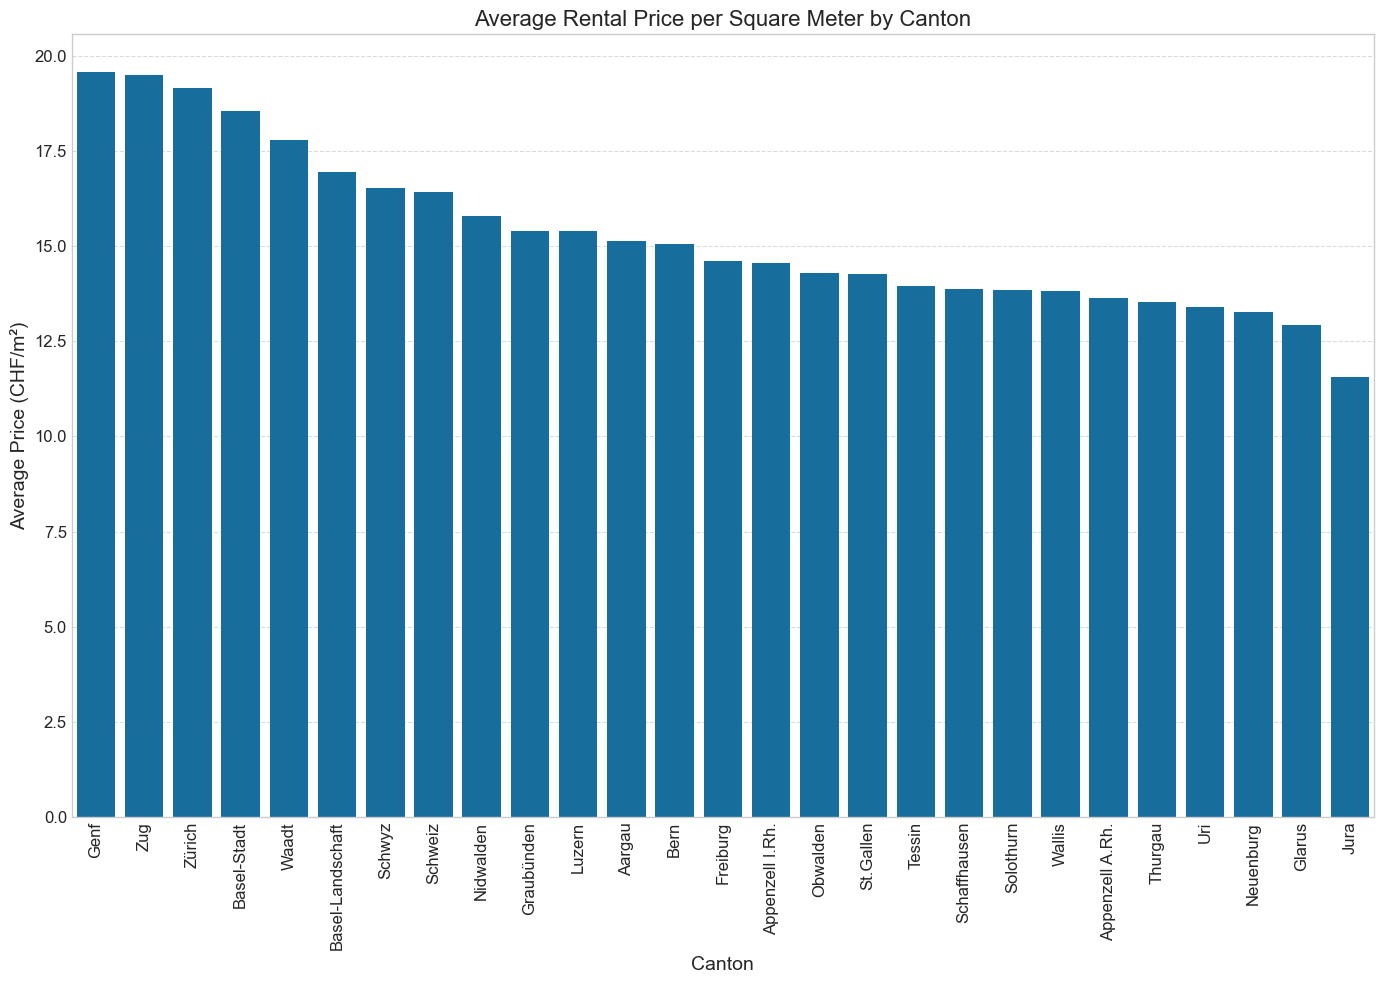

In [5]:
# Visualize rental prices by canton
plt.figure(figsize=(14, 10))
canton_avg = df.groupby('canton')['avg_price_per_sqm'].mean().sort_values(ascending=False)

sns.barplot(x=canton_avg.index, y=canton_avg.values)
plt.title('Average Rental Price per Square Meter by Canton', fontsize=16)
plt.xlabel('Canton', fontsize=14)
plt.ylabel('Average Price (CHF/m²)', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34492\221565632.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_avg = df.groupby('construction_period_cat')['avg_price_per_sqm'].mean()


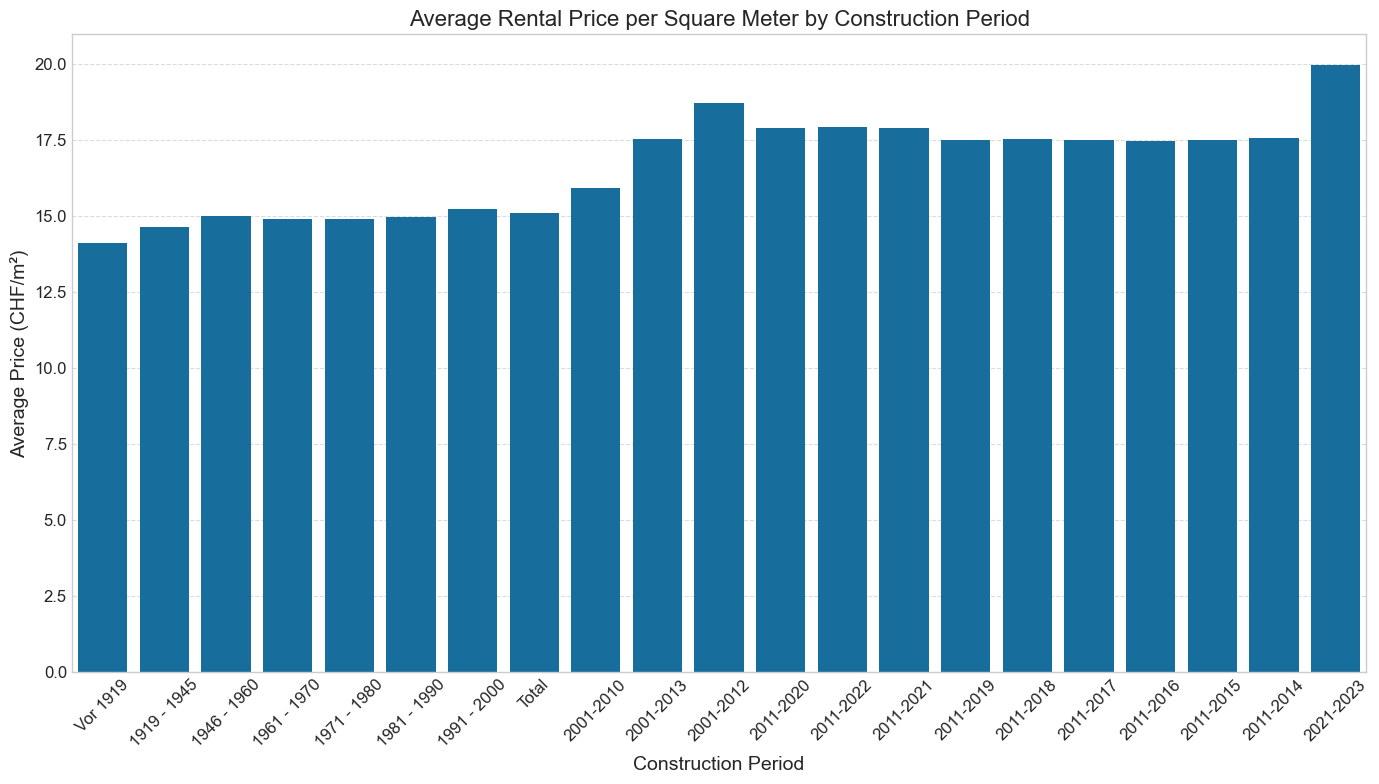


Trend Analysis:


TypeError: unsupported type: <class 'numpy.ndarray'>

In [6]:
# Visualize rental prices by construction period
# Convert construction period to category with sorted order for better visualization
period_order = sorted(df['construction_period'].unique(), 
                      key=lambda x: int(x.split('-')[0]) if '-' in x else 
                                  (1900 if 'vor' in x.lower() else 
                                   (2100 if 'nach' in x.lower() or 'ab' in x.lower() else 2000)))

df['construction_period_cat'] = pd.Categorical(df['construction_period'], categories=period_order, ordered=True)

plt.figure(figsize=(14, 8))
period_avg = df.groupby('construction_period_cat')['avg_price_per_sqm'].mean()

sns.barplot(x=period_avg.index, y=period_avg.values)
plt.title('Average Rental Price per Square Meter by Construction Period', fontsize=16)
plt.xlabel('Construction Period', fontsize=14)
plt.ylabel('Average Price (CHF/m²)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Check if there's a trend in prices across construction periods
print("\nTrend Analysis:")
print(f"Correlation between newer construction and price: {period_avg.corr(period_avg.index.codes)}")

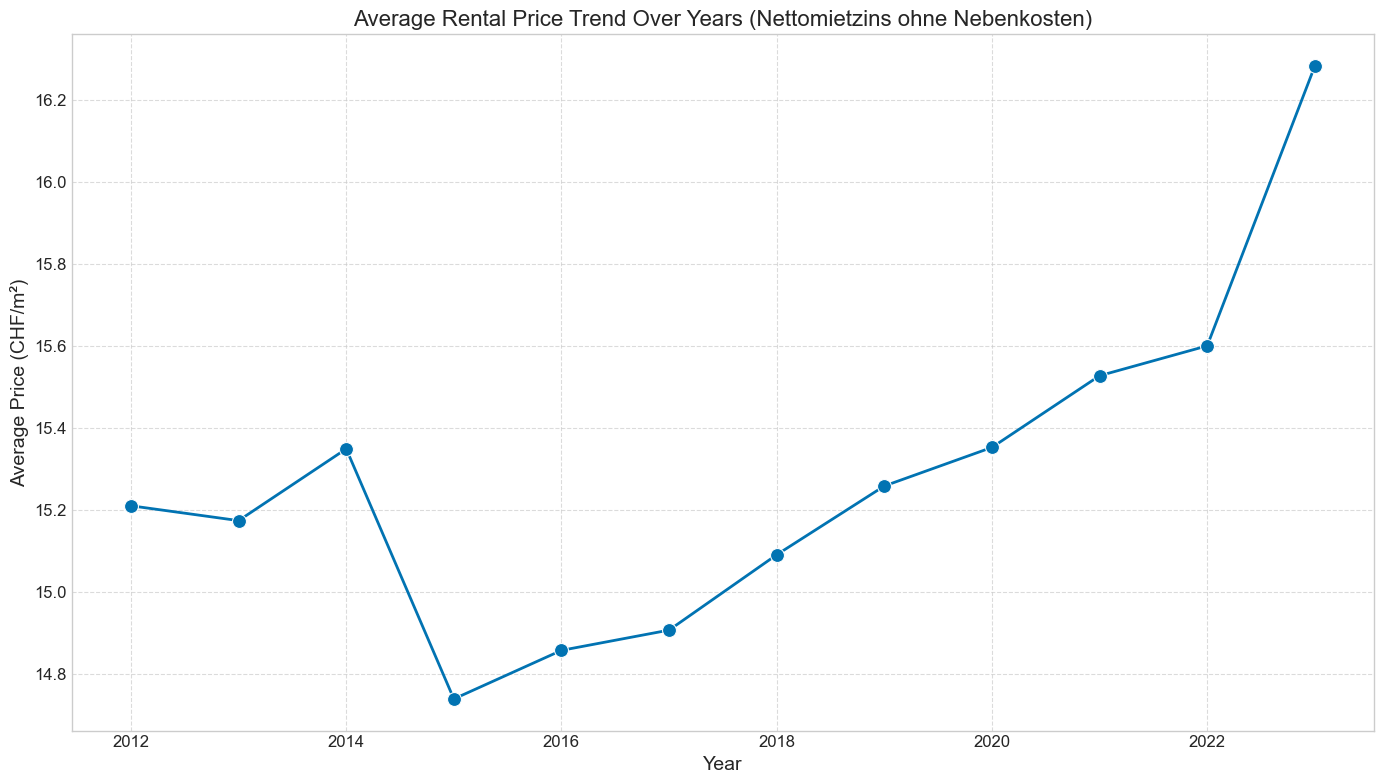

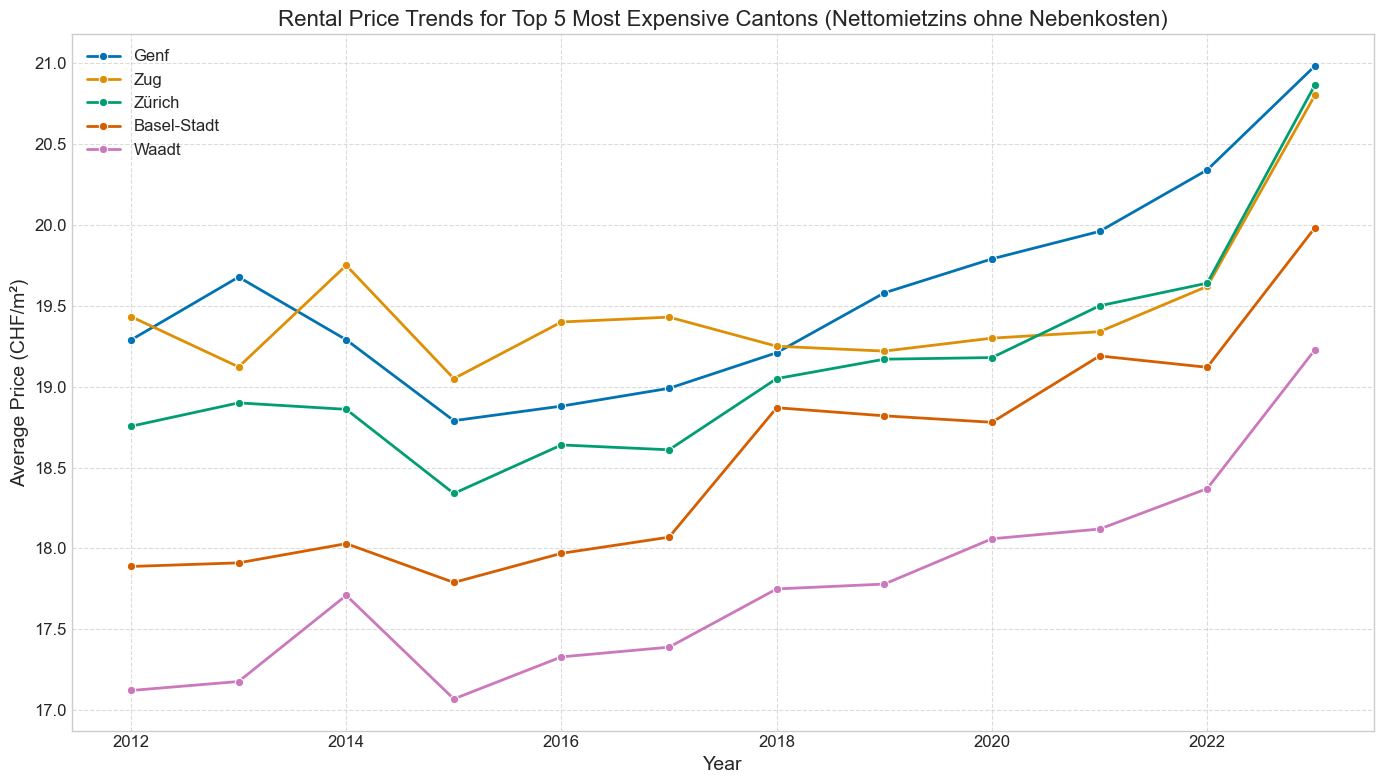

In [8]:
# If we have data across multiple years, visualize trends over time
if df['year'].nunique() > 1:
    plt.figure(figsize=(14, 8))
    year_avg = df.groupby('year')['avg_price_per_sqm'].mean()
    
    sns.lineplot(x=year_avg.index, y=year_avg.values, marker='o', linewidth=2, markersize=10)
    plt.title('Average Rental Price Trend Over Years (Nettomietzins ohne Nebenkosten)', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Average Price (CHF/m²)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Visualize trends for top 5 most expensive cantons
    top_cantons = canton_avg.head(5).index
    
    plt.figure(figsize=(14, 8))
    for canton in top_cantons:
        canton_data = df[df['canton'] == canton]
        canton_year_avg = canton_data.groupby('year')['avg_price_per_sqm'].mean()
        sns.lineplot(x=canton_year_avg.index, y=canton_year_avg.values, label=canton, marker='o', linewidth=2)
    
    plt.title('Rental Price Trends for Top 5 Most Expensive Cantons (Nettomietzins ohne Nebenkosten)', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Average Price (CHF/m²)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

C:\Users\Nevin\AppData\Local\Temp\ipykernel_34492\3391160570.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = pd.pivot_table(


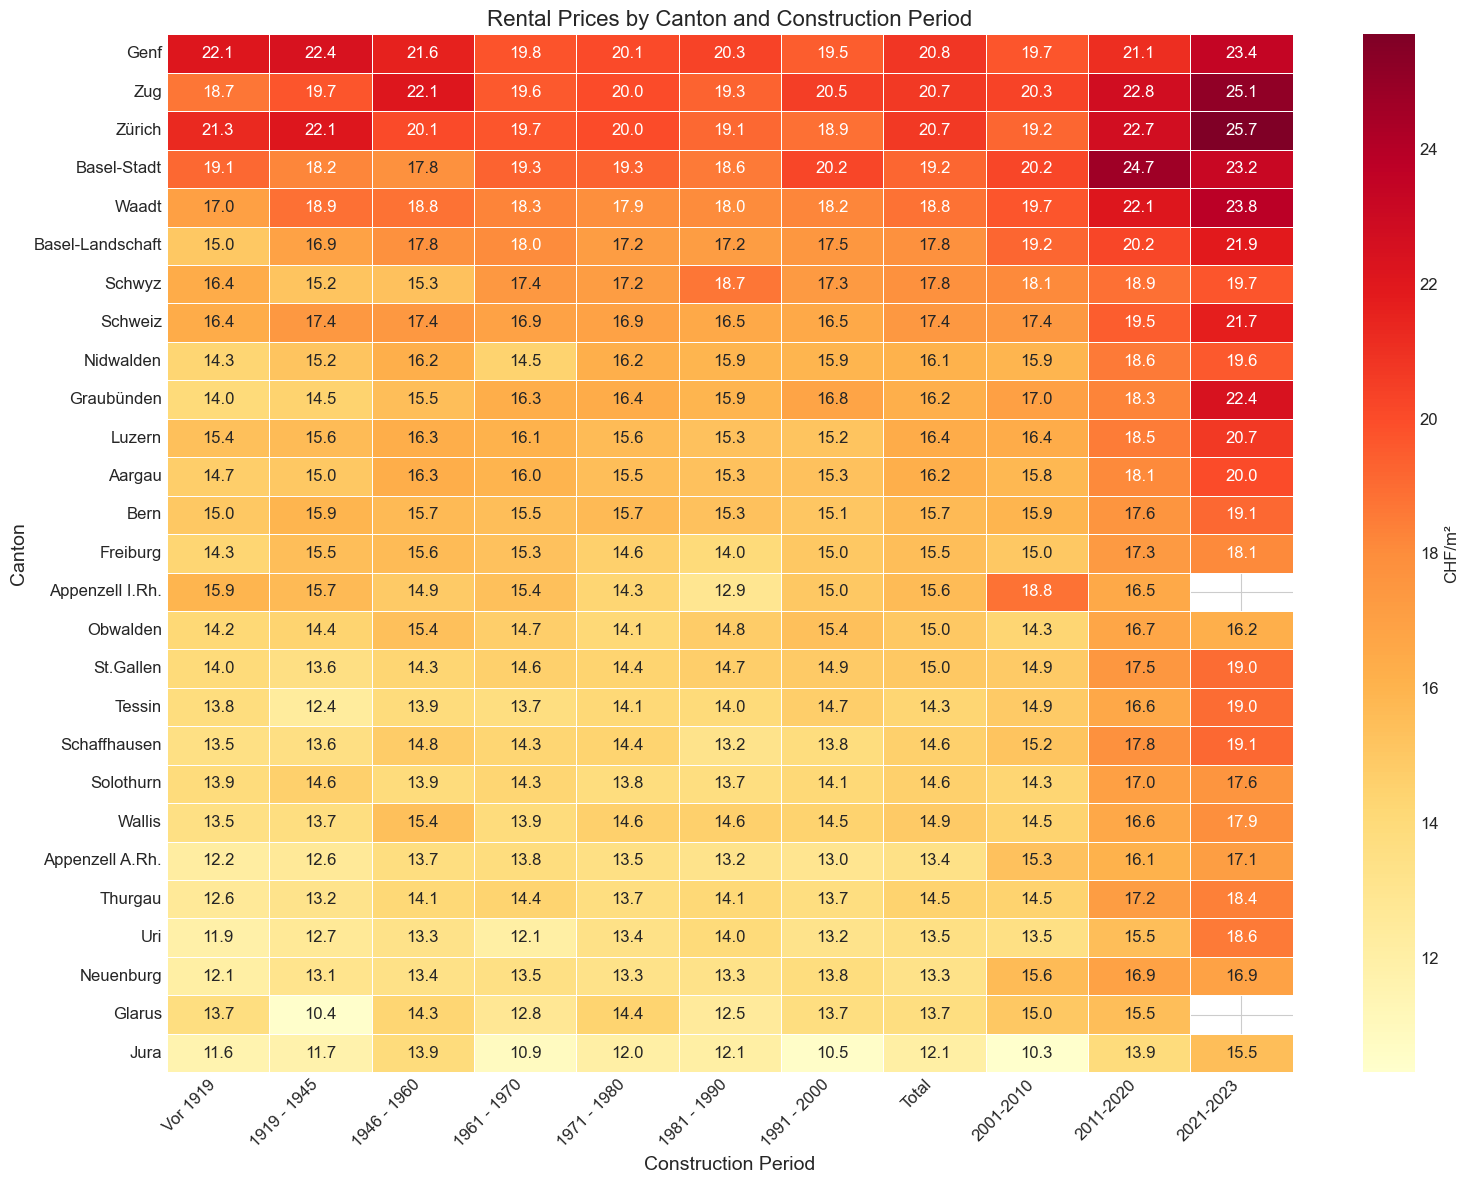

In [9]:
# Create a heatmap of prices by canton and construction period
# Use the most recent year if multiple years are available
if df['year'].nunique() > 1:
    latest_year = df['year'].max()
    heatmap_df = df[df['year'] == latest_year]
else:
    heatmap_df = df

# Create pivot table
pivot = pd.pivot_table(
    heatmap_df, 
    values='avg_price_per_sqm', 
    index='canton', 
    columns='construction_period_cat',
    aggfunc='mean'
)

# Sort cantons by average price
pivot = pivot.loc[canton_avg.index]

plt.figure(figsize=(16, 12))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5, cbar_kws={'label': 'CHF/m²'})
plt.title('Rental Prices by Canton and Construction Period', fontsize=16)
plt.xlabel('Construction Period', fontsize=14)
plt.ylabel('Canton', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()